## Expedia Hotel Clusters

In this notebook I explore models to match expedia booking events to hotel clusters. This challenge was part of a past Kaggle competition

Methods Used:
* Principal Component Analysis (PCA)
* KNN Classifiers
* Random Forrest Regressors

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy 

import random
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')

In [2]:
# Loading in Data
f = './Team Project/train.csv' # 4 GB file (training data)
kaggle = pd.read_csv(f)

f2 = './Team Project/destinations.csv' # 138 MB file (destinations data)
destinations = pd.read_csv(f2)

# Loading in testing data from kaggle
f3 = './Team Project/test.csv' # 277 MB file
expedia_test = pd.read_csv(f3)

In [3]:
print 'kaggle_train shape:\n', kaggle.shape
print 
print 'destinations shape:\n', destinations.shape
print
print 'kaggle_test shape:\n', expedia_test.shape

kaggle_train shape:
(37670293, 24)

destinations shape:
(62106, 150)

kaggle_test shape:
(2528243, 22)


In [4]:
destinations.head(3)

,srch_destination_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
0,0,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-1.897627,...,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657
1,1,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.165028,-2.181690,-2.181690,-2.031597,...,-2.165028,-2.181690,-2.165028,-2.181690,-2.181690,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690
2,2,-2.183490,-2.224164,-2.224164,-2.189562,-2.105819,-2.075407,-2.224164,-2.118483,-2.140393,...,-2.224164,-2.224164,-2.196379,-2.224164,-2.192009,-2.224164,-2.224164,-2.224164,-2.224164,-2.057548


**PCA on destinations dataframe**

In [5]:
# normalize the data by taking each feature and subtracting 
# by its mean and dividing by the standard deviation 
destinations_norm = (destinations[destinations.columns[1:]] - 
                     destinations[destinations.columns[1:]].mean(axis=0)) / destinations[destinations.columns[1:]].std(axis=0)

In [6]:
destinations_norm.head()

,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,...,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
0,-0.123235,0.102212,0.217838,-0.111515,-0.561366,1.086009,0.097105,0.124397,1.062035,-0.154254,...,0.146240,-0.029003,0.098977,0.163955,0.078548,0.122255,0.084036,0.255070,0.249206,0.019150
1,0.316596,0.515380,0.641039,2.692253,-0.305058,-0.883030,0.533428,0.588246,0.385089,0.321395,...,1.051113,0.254185,0.821863,0.593872,0.486369,1.001682,0.413152,0.701152,0.689109,0.418950
2,0.269950,-0.518929,-0.418386,0.108139,0.841089,-0.223093,-0.558846,2.316255,-0.164652,-0.869327,...,-0.540102,-0.454736,0.147948,-0.482366,0.238339,-0.544786,-0.410746,-0.415554,-0.412127,3.344201
3,0.427576,0.619632,0.747822,0.401642,-0.240385,-0.518210,0.643522,0.705285,-0.351691,0.441412,...,1.157332,0.325639,0.555723,0.702350,0.589272,0.677909,0.496196,0.813709,0.800106,0.519828
4,0.112546,0.367002,0.333801,0.552726,0.138884,-0.084738,0.216663,0.251498,-0.192533,-0.023920,...,0.450339,0.048595,0.246826,0.281758,0.190296,0.475205,0.174218,0.377303,0.369745,0.269401


In [7]:
X = destinations_norm[destinations_norm.columns[1:]].values

In [8]:
# Initialize PCA
# Can change n_components to decimal between 0, 1
# to keep the components that explain that percentage of variance
pca = PCA(n_components=None, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)

pca.fit(X)

# Exploring the principal components
print 'covariance matrix:', pca.get_covariance().shape
print pca.get_covariance()
print
print 'eigenvectors:', pca.components_.shape
print pca.components_
print
print 'eigenvalues:', pca.explained_variance_.shape
print pca.explained_variance_[:4] , '...'
print
print 'Explained Variance', pca.explained_variance_ratio_.shape
print pca.explained_variance_ratio_[:4], '...'
print
# Transform the data
Z = pca.transform(X)
print 'Principal Components (Z) shape:', Z.shape
print 'destinations data shape:', destinations.shape

covariance matrix: (148, 148)
[[ 0.9999839   0.60890449  0.37358053 ...,  0.62802468  0.62402453
   0.48403543]
 [ 0.60890449  0.9999839   0.45764101 ...,  0.8996559   0.89191232
   0.58745543]
 [ 0.37358053  0.45764101  0.9999839  ...,  0.42399875  0.41174039
   0.38034178]
 ..., 
 [ 0.62802468  0.8996559   0.42399875 ...,  0.9999839   0.93147533
   0.60214423]
 [ 0.62402453  0.89191232  0.41174039 ...,  0.93147533  0.9999839
   0.59138387]
 [ 0.48403543  0.58745543  0.38034178 ...,  0.60214423  0.59138387
   0.9999839 ]]

eigenvectors: (148, 148)
[[ -7.61208492e-02  -1.06380193e-01  -5.38048962e-02 ...,  -1.10273229e-01
   -1.10010477e-01  -7.26257594e-02]
 [ -3.49394923e-02  -1.33146884e-02  -1.68852392e-01 ...,   1.07735226e-02
    1.73613519e-02  -6.98085248e-02]
 [ -1.76489333e-03  -3.16989690e-03   1.21221319e-01 ...,  -2.47001913e-02
   -2.67634678e-02  -7.93390972e-03]
 ..., 
 [  6.33730408e-04   7.07453498e-03   1.86294215e-03 ...,   1.64355740e-02
    8.43615700e-03  -2.7040

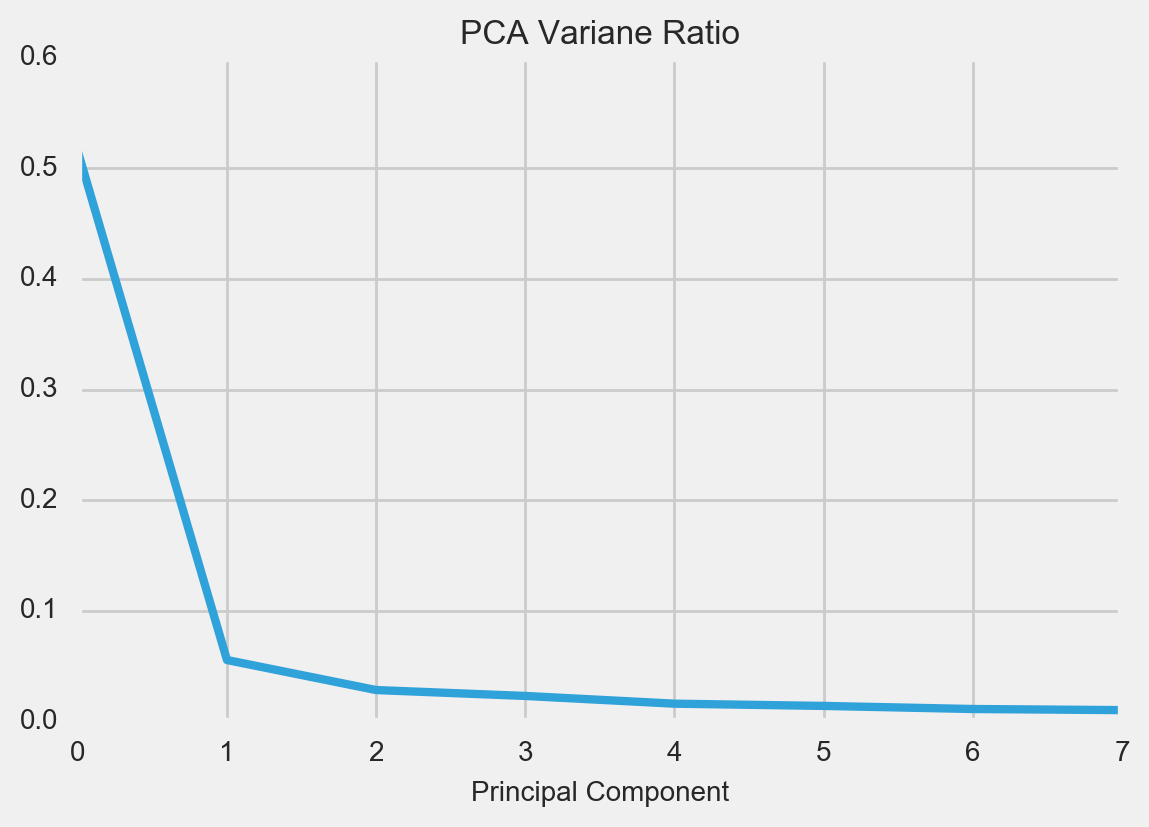

In [9]:
plt.plot(range(len(pca.explained_variance_ratio_)),pca.explained_variance_ratio_, linewidth=3)
plt.xlim(0, 7)
plt.title('PCA Variane Ratio', fontsize=12)
plt.xlabel('Principal Component', fontsize=10)
plt.show()

In [10]:
print pca.explained_variance_ratio_[:5]
print pca.explained_variance_ratio_[:5].sum()

[ 0.51516879  0.05559734  0.02845729  0.02312793  0.01614499]
0.638496335655


In [11]:
pca_df = pd.DataFrame(Z).iloc[:, :5]
pca_df['srch_destination_id'] = destinations["srch_destination_id"]

In [12]:
pca_df.head()

,0,1,2,3,4,srch_destination_id
0,-1.191670,1.448742,-0.713557,-0.468854,1.123818,0
1,-6.601063,-0.223687,0.619043,-0.929023,-0.027499,1
2,1.180280,0.240480,0.864941,3.081409,-2.934395,2
3,-7.347883,-0.373657,-0.044201,-0.685944,0.102526,3
4,-3.730418,-0.574749,0.397904,0.520545,0.074723,4


**_...done with PCA..._**

** Kaggle-Expedia Data **

In [13]:
kaggle.head(3).T

,0,1,2
date_time,2014-08-11 07:46:59,2014-08-11 08:22:12,2014-08-11 08:24:33
site_name,2,2,2
posa_continent,3,3,3
user_location_country,66,66,66
user_location_region,348,348,348
user_location_city,48862,48862,48862
orig_destination_distance,2234.26,2234.26,2234.26
user_id,12,12,12
is_mobile,0,0,0
is_package,1,1,0


In [14]:
kaggle.user_id.unique().shape

(1198786,)

In [15]:
# Filter out for only booked info
print 'Full Expedia data:', kaggle.shape
expedia_train = kaggle[kaggle.is_booking == 1]
expedia_train.reset_index(drop=True, inplace=True)
print 'Expedia data (is_booking == 1):', expedia_train.shape

Full Expedia data: (37670293, 24)
Expedia data (is_booking == 1): (3000693, 24)


In [16]:
del destinations
del destinations_norm
del kaggle

**Functions to clean Expedia dataset**

In [17]:
def clean_time_cols(expedia_df):
    '''
    Input(s): Expedia DataFrame w/o duration column
    Output(s): Expedia DataFrame with cleaned datetime columns and duration column
    '''
    
    # Converting date_time columns to datetime
    expedia_df.date_time = pd.to_datetime(expedia_df.date_time, errors='coerce')
    
    # check_in & check_out columns
    expedia_df.srch_ci = pd.to_datetime(expedia_df.srch_ci, errors='coerce')
    expedia_df.srch_co = pd.to_datetime(expedia_df.srch_co, errors='coerce')
        
    # duration in days (ints)
    expedia_df['duration'] = (expedia_df.srch_co - 
                             expedia_df.srch_ci).fillna(value='1').apply(lambda x: x.days)

    # Setting Negative durations to 0
    expedia_df.duration = expedia_df.duration.map(lambda x: 1 if x < 0 else x)
    
    return expedia_df

    
def merge_exp_pca(expedia_df, pca_df):
    '''
    Input(S): Expedia Dataframe & PCA Dataframe
    Output(S): Merged Dataframe
    '''
    # Merge expedia with principal components
    expedia_df = pd.merge(left=expedia_df, right=pca_df, how='left', on='srch_destination_id')

    # Filling in NaN PCA columns
    expedia_df[expedia_df.columns[-5:]] = expedia_df[expedia_df.columns[-5:]].fillna(expedia_df[expedia_df.columns[-5:]].mean())

    return expedia_df


def distance_cat(dist):
    '''
    Helper function for orig_destination inputations
    Input(s): Distance value from orig_destination_distance (expedia_df)
    Output(s): Distance Label based on orig_destination_distance (expedia_df)
    '''
    if np.isnan(dist):
        return np.nan
    elif dist <= 2000:
        return 1
    elif dist <= 6000:
        return 2
    else:
        return 3


def knn_impute_y(expedia_df, k=5): 
    '''
    Input(s): Expedia DataFrame w/ orig_dis categories, & category vector (for NaN imputation)
    Output(s): Expedia DataFrame - cleaned
    '''
    
    # Mapping numerical value to category
    dists = expedia_df.groupby(by='orig_dis_label')['orig_destination_distance'].mean().to_dict()

    # Temporary df containing NA values for orig_dis_label
    exp_nan = expedia_df.loc[expedia_df.orig_dis_label.isnull(), :] 

    # Imputing the distance values
    exp_nan.orig_dis_label = knn_pred_orig_dis(expedia_df, k=k) # Function for imputing
    exp_nan.orig_destination_distance = exp_nan.orig_dis_label.map(dists)

    # Concatenating the imputed df with the non-Null df
    expedia_clean = pd.concat([expedia_df.loc[~expedia_df.orig_dis_label.isnull(), :], exp_nan], axis=0).reset_index(drop=True)
    expedia_clean.drop(labels='orig_dis_label', axis=1, inplace=True) 
    
    return expedia_clean


def knn_pred_orig_dis(expedia_df, k=5):
    '''
    Input(s): Expedia DataFrame w/ orig_dis categories
    Process: Inpute orig_dest values using KNN classification
    Output(s): y vector of categories for missing orig_dis
    '''
    # Predictors used for KNN classifier
    cols = [u'user_location_country', u'user_location_region', 
            u'user_location_city', u'hotel_market', u'orig_dis_label']
    
    # Setting X, y for model (non-NA values to train model)
    # Predict on the NA values of orig_distance
    X = expedia_df.loc[~expedia_df.orig_dis_label.isnull(), cols[:-1]].values 
    y = expedia_df.loc[~expedia_df.orig_dis_label.isnull(), cols[-1:]].values
    y.resize(y.shape[0])
    
    # Fitting KNN Model
    knn = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    knn.fit(X, y)
    
    # Predicting categories for NA values of
    # orig_dis_label which corresponds to orig_destination_distance
    y_impute = knn.predict(expedia_df.loc[expedia_df.orig_dis_label.isnull(), cols[:-1]].values)
    
    return y_impute

def plot_duration(expedia_df):
    '''
    Input(s): Expedia DataFrame w/ duration column
    Output(s): Distribution plot of duration
    '''
    # Plotting the distribution of duration
    sns.distplot(expedia_df.duration, bins=50) # expedia_df
    plt.title('Length of Stay', fontsize=12) 
    plt.xlabel('Days', fontsize=10) 
    plt.ylabel('frequency', fontsize=10)
    plt.show()

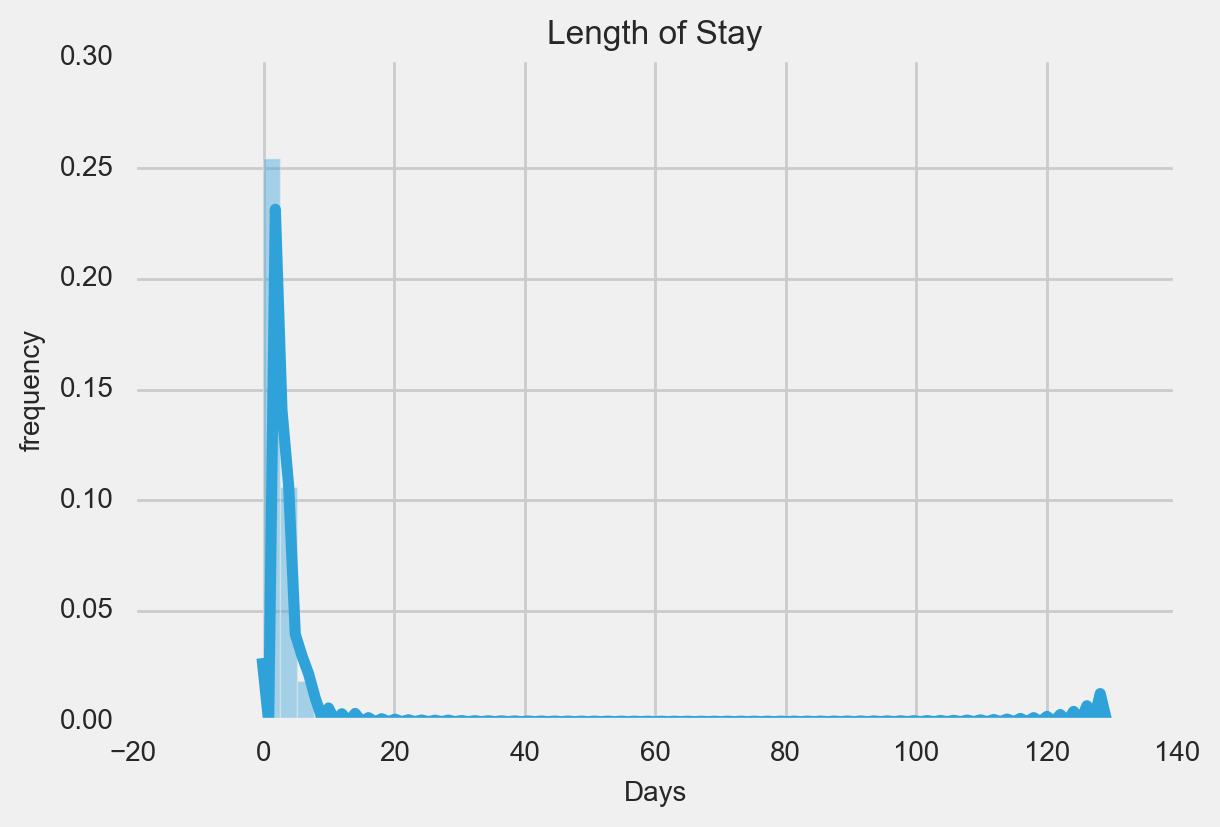

In [18]:
# Clean date_time columns from expedia
expedia_train = clean_time_cols(expedia_train)

# Plotting Duration
plot_duration(expedia_train)

In [19]:
# Merge Principal Components to Expedia Data
expedia_train = merge_exp_pca(expedia_train, pca_df)

# Apply helper function to create categroy column
expedia_train['orig_dis_label'] = expedia_train.orig_destination_distance.map(distance_cat)

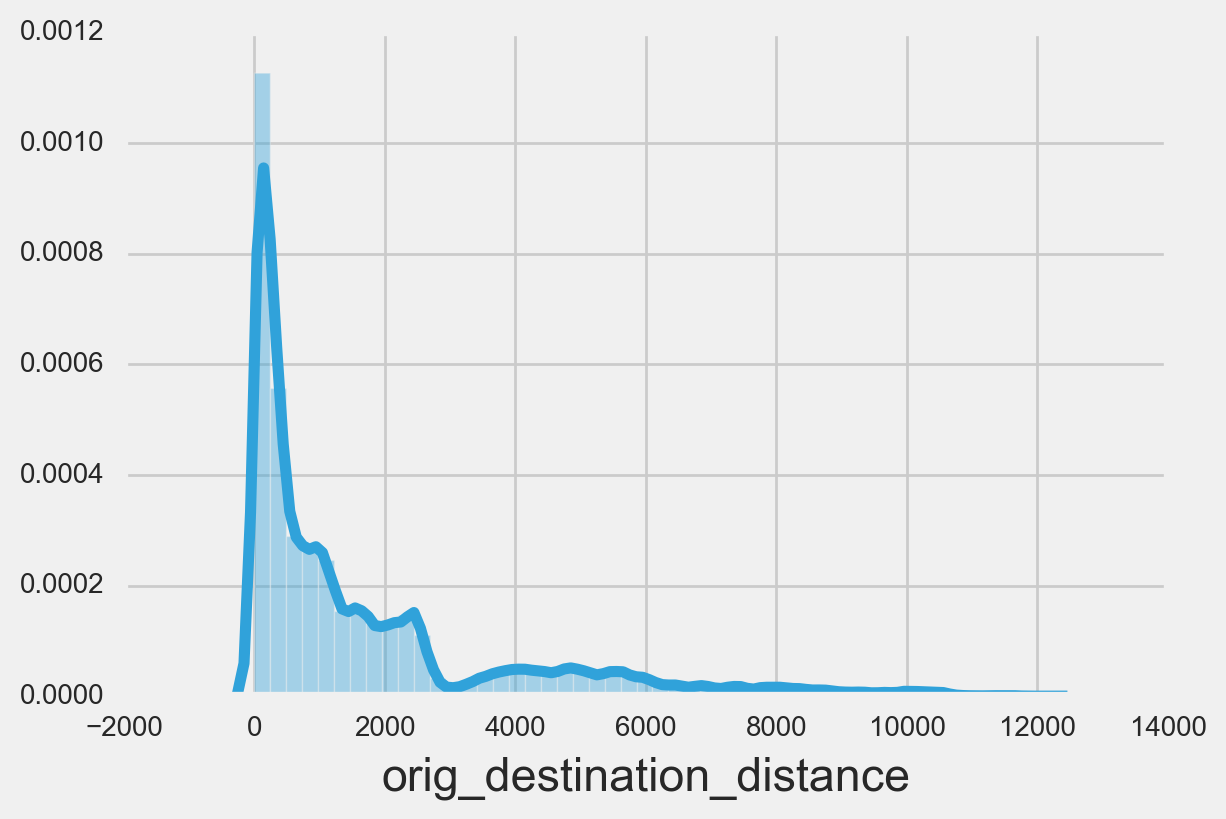

In [20]:
# orig_destination_distance distribution
sns.distplot(expedia_train.orig_destination_distance.dropna(axis=0)) 
plt.show()

In [21]:
# Imputing orig_destination_distance using KNN classification
expedia_train = knn_impute_y(expedia_train)

/Users/Smitty/anaconda/envs/dsi/lib/python2.7/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


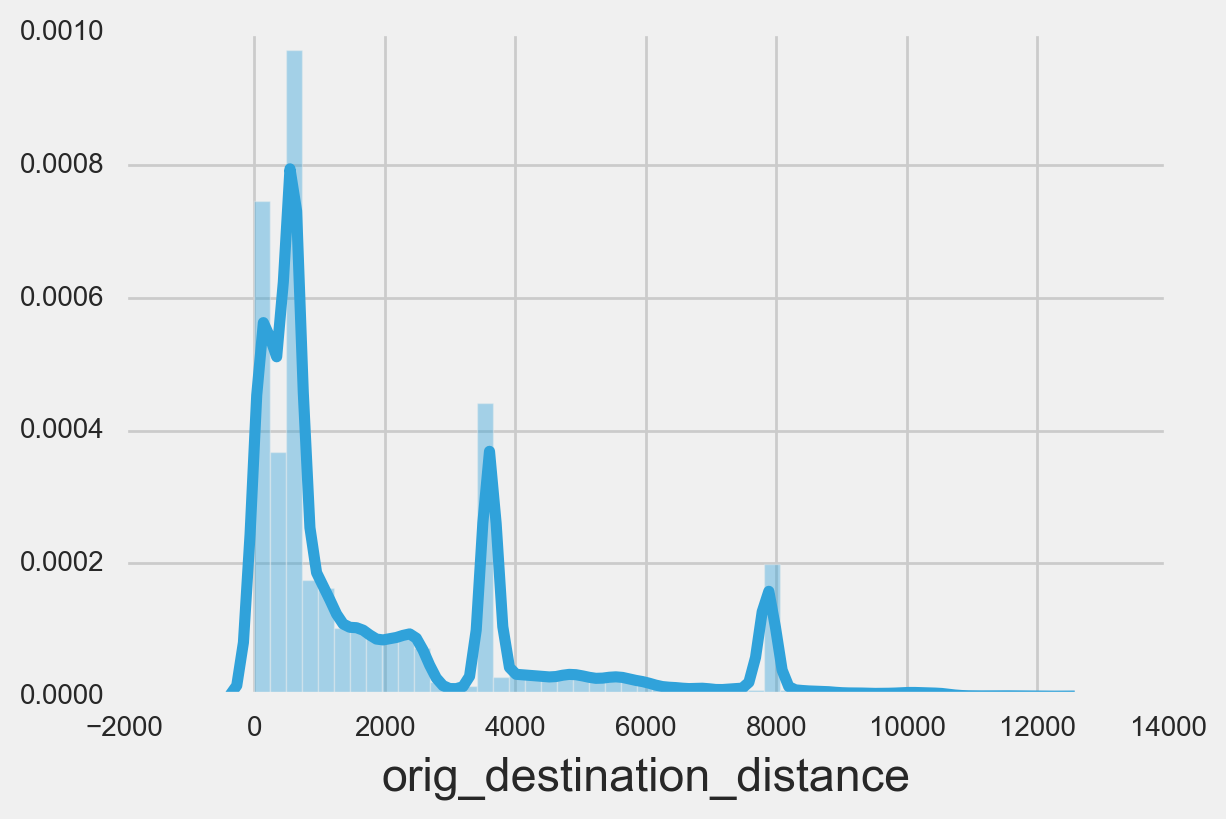

In [22]:
# orig_destination_distance distribution
sns.distplot(expedia_train.orig_destination_distance.dropna(axis=0)) 
plt.show()

In [23]:
expedia_train.isnull().sum()

date_time                    0
site_name                    0
posa_continent               0
user_location_country        0
user_location_region         0
user_location_city           0
orig_destination_distance    0
user_id                      0
is_mobile                    0
is_package                   0
channel                      0
srch_ci                      0
srch_co                      0
srch_adults_cnt              0
srch_children_cnt            0
srch_rm_cnt                  0
srch_destination_id          0
srch_destination_type_id     0
is_booking                   0
cnt                          0
hotel_continent              0
hotel_country                0
hotel_market                 0
hotel_cluster                0
duration                     0
0                            0
1                            0
2                            0
3                            0
4                            0
dtype: int64

In [24]:
# AND NOW THE MODELS FOR PREDICTING CLUSTERS
# make appropriate columns for X (predictors) and y (target)
drop_cols = ['date_time', 'user_id', 'srch_ci', 'srch_co', 'is_booking', 
             'hotel_cluster', 'cnt']
keep_cols = [x for x in expedia_train.columns if x not in drop_cols]

# Design matrix and target
X = expedia_train[keep_cols]
y = expedia_train.hotel_cluster.values

In [25]:
# Random Forest Classifier to predict clusters

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

rfr = RandomForestClassifier(n_estimators=10, n_jobs=2)
rfr.fit(X_train,y_train)
y_pred = rfr.predict(X_test) 

In [26]:
# Top 5 hotel_clusters in y_test
print 'top 5 clusters:', pd.DataFrame(y_test, columns=['cluster'])['cluster'].value_counts()[:5].sum()
print 'y_test samples:', y_test.shape[0]
print 'baseline acc:', pd.DataFrame(y_test, columns=['cluster'])['cluster'].value_counts()[:5].sum()/float(y_test.shape[0])

top 5 clusters: 122982
y_test samples: 900208
baseline acc: 0.136615093401


In [27]:
# Evaluating Model. However this isn't 
# the real accuracy
rfr.score(X_test,y_test)

0.20368292661251622

In [28]:
# Feature importances
sorted(zip(X.columns, rfr.feature_importances_), key=lambda x: x[1], reverse=True)

[('orig_destination_distance', 0.19958021361993131),
 ('user_location_city', 0.17696164477976142),
 ('user_location_region', 0.11490217379860475),
 ('duration', 0.076160479103645193),
 ('channel', 0.07536359138381904),
 ('srch_adults_cnt', 0.053096843915437938),
 ('user_location_country', 0.034754442254057605),
 ('srch_children_cnt', 0.032796200464474803),
 ('site_name', 0.025291885314908207),
 (0, 0.022094015456439266),
 (3, 0.02019711306768044),
 ('is_mobile', 0.019990573439899191),
 (2, 0.019425791732495964),
 ('hotel_market', 0.019321027797484912),
 (1, 0.019023462755897273),
 ('srch_rm_cnt', 0.018928020930990316),
 (4, 0.01722989877093415),
 ('srch_destination_id', 0.016340477290879628),
 ('posa_continent', 0.010266562274812601),
 ('is_package', 0.0087089439891484439),
 ('hotel_continent', 0.0073549921422383646),
 ('hotel_country', 0.0069108333355400757),
 ('srch_destination_type_id', 0.00530081238091905)]

In [29]:
# predict probabilities to sort top five for each row
prob_arr = rfr.predict_proba(X_test)

In [30]:
# test
sorted(zip(rfr.classes_, prob_arr[22]), key=lambda x: x[1], reverse=True)[:10]

[(2, 0.20000000000000001),
 (97, 0.20000000000000001),
 (25, 0.10000000000000001),
 (29, 0.10000000000000001),
 (42, 0.10000000000000001),
 (59, 0.10000000000000001),
 (64, 0.10000000000000001),
 (46, 0.050000000000000003),
 (82, 0.050000000000000003),
 (0, 0.0)]

In [31]:
# make list of top five for each row
preds_5 = []
for i in range(len(y_pred)):
        preds_5.append([x[0] for x in sorted(zip(rfr.classes_, 
                                                 prob_arr[i]), key=lambda x: x[1], reverse=True)[:5]])
in_5er = 0
for i in range(len(preds_5)):
    if y_test[i] in preds_5[i]:
        in_5er +=1
print in_5er
print len(preds_5)

417403
900208


** Error Analysis **

In [32]:
tp = np.zeros(100)
fp = np.zeros(100)

in_5er = 0
for i in range(len(preds_5)):
    if y_test[i] in preds_5[i]:
        in_5er +=1
        tp[y_test[i]] += 1
    else:
        fp[y_test[i]] += 1

In [33]:
tp_fp = pd.DataFrame(range(100), columns=['hotel_cluster'])
tp_fp['TP'] = tp
tp_fp['FP'] = fp
tp_fp['total'] = tp + fp
tp_fp = tp_fp.astype(int)
tp_fp['precision'] = tp / (tp + fp)

In [34]:
tp_fp.head()

,hotel_cluster,TP,FP,total,precision
0,0,4165,1596,5761,0.722965
1,1,10869,648,11517,0.943735
2,2,7185,6402,13587,0.528814
3,3,1185,2516,3701,0.320184
4,4,5319,5282,10601,0.501745


In [246]:
tp_fp.loc[tp_fp.hotel_cluster == 91, :]

,hotel_cluster,TP,FP,total,precision
91,91,18802,17281,36083,0.521076


In [60]:
top_10 = tp_fp[['hotel_cluster', 'precision']].sort_values(by='precision', ascending=False).reset_index(drop=True).head(10)
bottom_10 = tp_fp[['hotel_cluster', 'precision']].sort_values(by='precision', ascending=False).reset_index(drop=True).tail(10)

In [61]:
top_10

,hotel_cluster,precision
0,74,0.971660
1,1,0.943735
2,27,0.908313
3,65,0.885719
4,80,0.768627
5,45,0.740236
6,66,0.728064
7,0,0.722965
8,54,0.696010
9,52,0.680572


In [62]:
bottom_10

,hotel_cluster,precision
90,97,0.288874
91,53,0.283333
92,84,0.278934
93,76,0.271873
94,83,0.270852
95,89,0.259822
96,90,0.253620
97,60,0.252111
98,86,0.232037
99,93,0.164404


_The following precision graphs show us that we do a better job predicting the hotel clusters that were least represented in the training data. This must indicate that our model doesn't capture the complexities of the larger hotel clusters such as id:97_

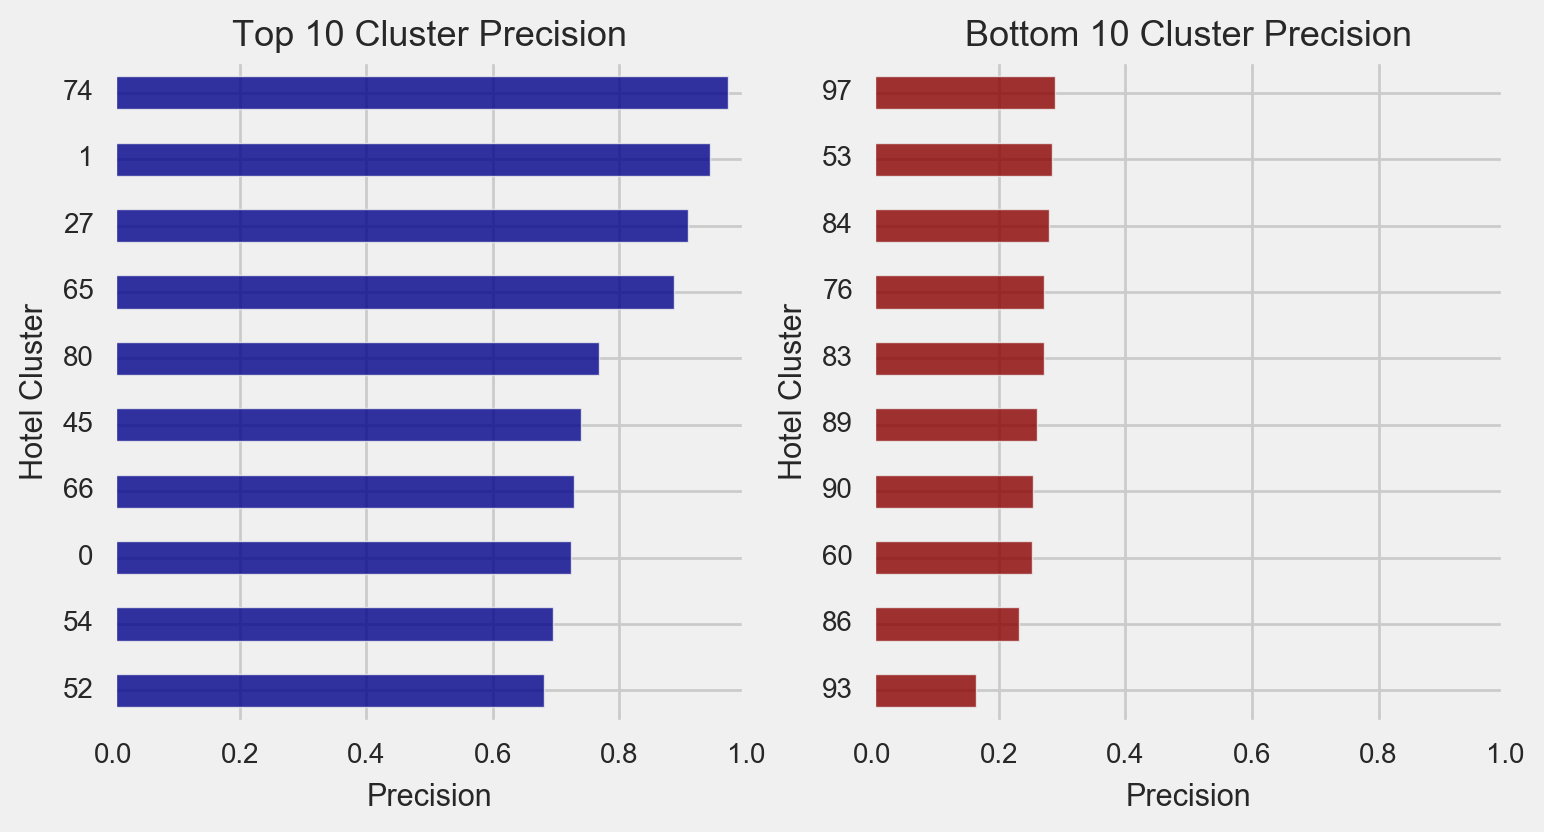

In [128]:
fig, ax = plt.subplots(1,2, sharey=False, figsize=(8, 4))

ax[0].barh(range(10), top_10.precision.sort_values(ascending=True), 
           height=0.5, align='center', color='darkblue', alpha=0.8)
ax[0].set_ylim(-0.5, 9.5)
ax[0].set_yticks( range(10))
ax[0].set_yticklabels(top_10.hotel_cluster.astype(str)[::-1])

ax[0].set_ylabel('Hotel Cluster', fontsize=11)
ax[0].set_xlabel('Precision', fontsize=11)
ax[0].set_title('Top 10 Cluster Precision', fontsize=13)


ax[1].barh(range(10), bottom_10.precision.sort_values(ascending=True), 
           height=0.5, align='center', color='darkred', alpha=0.8)
ax[1].set_ylim(-0.5, 9.5)
ax[1].set_xlim(0, 1)
ax[1].set_yticks( range(10))
ax[1].set_yticklabels(bottom_10.hotel_cluster.astype(str)[::-1])

ax[1].set_ylabel('Hotel Cluster', fontsize=11)
ax[1].set_xlabel('Precision', fontsize=11)
ax[1].set_title('Bottom 10 Cluster Precision', fontsize=13)

plt.show()

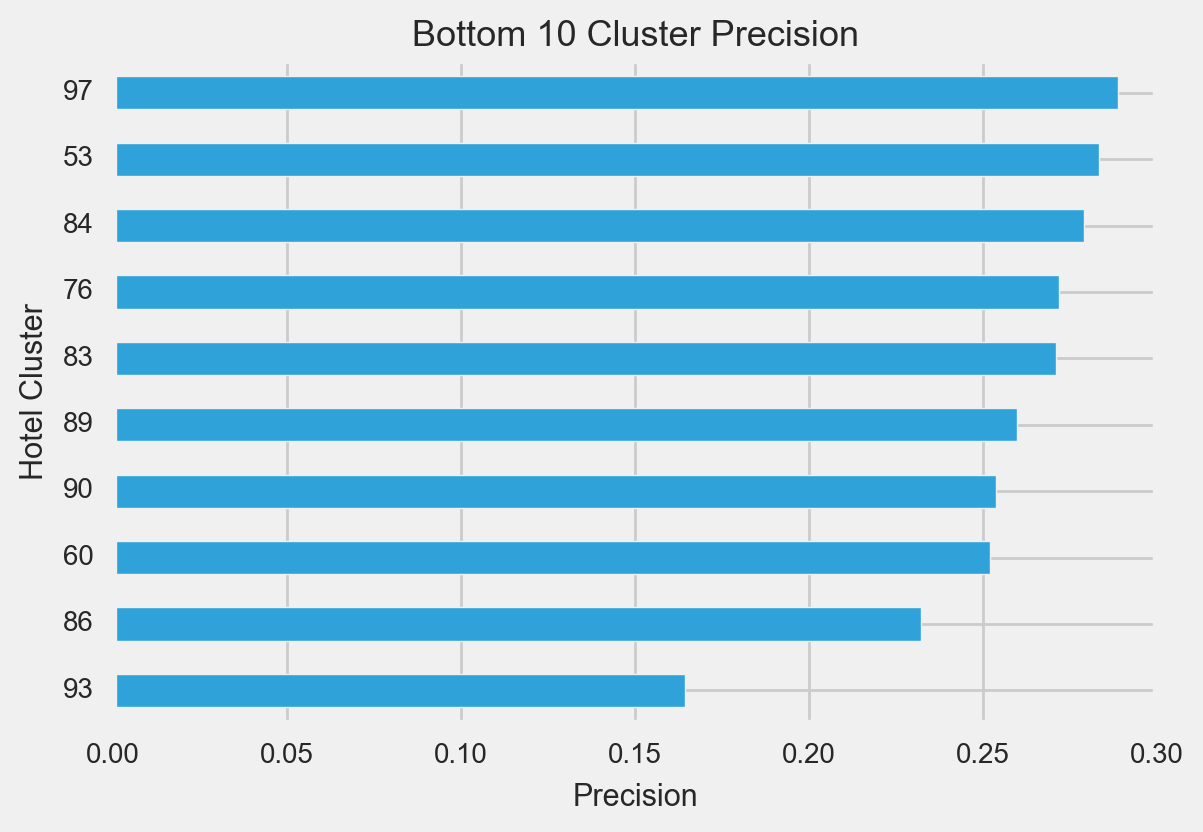

In [87]:
bottom_10.precision.sort_values(ascending=True).plot(kind='barh')
plt.yticks( range(10),  bottom_10.hotel_cluster.astype(str)[::-1])
plt.ylabel('Hotel Cluster', fontsize=11)
plt.xlabel('Precision', fontsize=11)
plt.title('Bottom 10 Cluster Precision', fontsize=13)
plt.show()

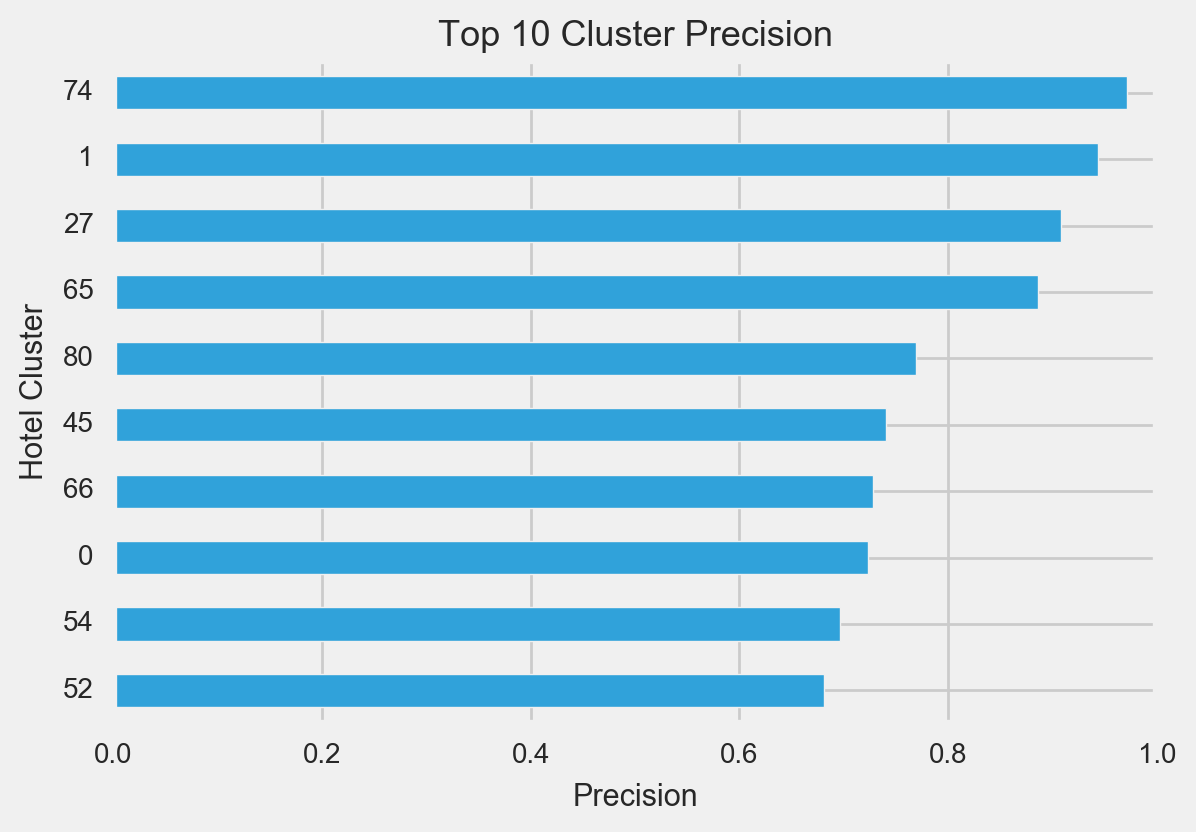

In [79]:
top_10.precision.sort_values(ascending=True).plot(kind='barh')
plt.yticks( range(10),  top_10.hotel_cluster.astype(str)[::-1])
plt.ylabel('Hotel Cluster', fontsize=11)
plt.xlabel('Precision', fontsize=11)
plt.title('Top 10 Cluster Precision', fontsize=13)
plt.show()

In [129]:
print 'mean precision', tp_fp.precision.mean()

mean precision 0.46156298139


In [131]:
tp_fp.loc[tp_fp.hotel_cluster == 97, :]

,hotel_cluster,TP,FP,total,precision
97,97,2560,6302,8862,0.288874


In [132]:
drop_cols = [u'date_time', u'user_id', u'srch_ci', u'srch_co', 
            u'is_booking', u'cnt']

keep_cols = [x for x in expedia_train.columns if x not in drop_cols]

In [133]:
cluster_means = expedia_train[keep_cols].groupby(by='hotel_cluster').mean()

In [134]:
cluster_means.head()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,is_mobile,is_package,channel,srch_adults_cnt,...,srch_destination_type_id,hotel_continent,hotel_country,hotel_market,duration,0,1,2,3,4
hotel_cluster,,,,,,,,,,,,,,,,,,,,,
0,6.161180,2.886722,82.166745,282.345660,27190.614500,1800.246443,0.114891,0.322931,6.081760,2.042752,...,2.595725,2.414209,50.261195,564.105217,3.392781,19.691583,6.047726,3.382814,1.121558,-2.082251
1,6.802341,2.851886,90.634200,291.787906,27977.842913,1337.032335,0.100572,0.366892,6.222809,2.039818,...,2.501977,2.000000,50.000000,627.978804,3.007490,42.229555,4.077685,-10.096090,-3.069127,0.590741
2,12.793563,2.489513,86.315681,362.885118,28610.741560,2812.026408,0.092487,0.169704,6.122473,1.846144,...,2.661680,4.106758,89.264033,431.888115,2.370281,9.490663,-3.394572,1.651160,0.344499,0.522753
3,12.033513,2.501007,84.781761,301.247160,27751.580440,2608.347983,0.079433,0.090470,6.094256,1.832917,...,2.954161,3.722388,95.690164,772.799243,2.623943,5.327781,-1.628510,1.284962,0.278285,0.380214
4,7.886566,2.868892,97.248504,300.774649,28019.011549,1266.065872,0.098626,0.091517,6.347214,1.852651,...,3.450982,2.178510,74.614431,605.068420,1.982719,15.412141,-1.585289,-0.070677,0.912580,-0.886691


In [135]:
ss = StandardScaler()
cluster_norm = ss.fit_transform(cluster_means)

In [136]:
cluster_norm.shape

(100, 23)

In [137]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

In [138]:
neigh = NearestNeighbors(n_neighbors=5, radius=1.0)
neigh.fit(cluster_norm)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [139]:
X_test_norm = ss.fit_transform(X_test)

In [140]:
X_test_norm.shape

(900208, 23)

In [141]:
# Run this when expedia test data is clean
knn_pred = neigh.kneighbors(X_test_norm, n_neighbors=5, return_distance=False)

In [142]:
knn_pred.shape

(900208, 5)

In [144]:
y_test[:10]

array([47,  9, 18, 55, 45, 44, 93, 23, 18, 48])

_Precision after normalizing went from 37k / 900k to 160k / 900k_

In [145]:
in_5er = 0
for i in range(knn_pred.shape[0]):
    if y_test[i] in knn_pred[i]:
        in_5er +=1
print in_5er
print knn_pred.shape[0]

159786
900208


In [146]:
knn_pred[:5]

array([[47, 16, 48, 33, 13],
       [77, 32, 42, 13, 50],
       [15, 76, 14, 83, 89],
       [10, 55, 83, 37, 15],
       [45, 24, 88,  1, 79]])

Plan:

Add signals as features to the dataset and then predict

In [181]:
# Applying Nearest Neigbors to add similar clusters as features
# First normalizing the data

keep_cols = [x for x in expedia_train.columns if (x not in drop_cols) & (x != 'hotel_cluster')]

X_all_obs = ss.fit_transform(expedia_train[keep_cols])

In [182]:
X_all_obs.shape

(3000693, 23)

In [183]:
knn_pred = neigh.kneighbors(X_all_obs, n_neighbors=5, return_distance=False)

In [184]:
knn_pred.shape

(3000693, 5)

In [187]:
knn_pred[:,0]

(3000693,)

In [189]:
# GOAL: ADD columns of similar clusters to dataset for each observation
expedia_data = expedia_train[keep_cols]

In [194]:
for i in range(5):
    expedia_data['sim_clus_%s' % i] = knn_pred[:, i]

/Users/Smitty/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [197]:
# New Data
expedia_data.columns

Index([                u'site_name',            u'posa_continent',
           u'user_location_country',      u'user_location_region',
              u'user_location_city', u'orig_destination_distance',
                       u'is_mobile',                u'is_package',
                         u'channel',           u'srch_adults_cnt',
               u'srch_children_cnt',               u'srch_rm_cnt',
             u'srch_destination_id',  u'srch_destination_type_id',
                 u'hotel_continent',             u'hotel_country',
                    u'hotel_market',                  u'duration',
                                  0,                            1,
                                  2,                            3,
                                  4,                u'sim_clus_0',
                      u'sim_clus_1',                u'sim_clus_2',
                      u'sim_clus_3',                u'sim_clus_4'],
      dtype='object')

In [204]:
expedia_data.shape

(3000693, 28)

In [203]:
# Design matrix and target
X = expedia_data
y = expedia_train.hotel_cluster.values

In [205]:
# Random Forest Classifier to predict clusters

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

rfr = RandomForestClassifier(n_estimators=10, n_jobs=2)
rfr.fit(X_train,y_train)
y_pred = rfr.predict(X_test) 

In [208]:
# Top 5 hotel_clusters in y_test
print 'top 5 clusters:', pd.DataFrame(y_test, columns=['cluster'])['cluster'].value_counts()[:5].sum()
print 'y_test samples:', y_test.shape[0]
print 'baseline acc:', pd.DataFrame(y_test, columns=['cluster'])['cluster'].value_counts()[:5].sum()/float(y_test.shape[0])

top 5 clusters: 122982
y_test samples: 900208
baseline acc: 0.136615093401


In [209]:
# Evaluating Model. However this isn't 
# the real accuracy
rfr.score(X_test,y_test)

0.19257882622682757

In [210]:
# Feature importances
sorted(zip(X.columns, rfr.feature_importances_), key=lambda x: x[1], reverse=True)

[('orig_destination_distance', 0.14547388069265793),
 ('user_location_city', 0.11573571305464432),
 ('user_location_region', 0.07768530543813898),
 ('sim_clus_4', 0.072161135097086271),
 ('sim_clus_3', 0.066525969063064128),
 ('sim_clus_2', 0.060541404251822674),
 ('duration', 0.054726585287192805),
 ('sim_clus_1', 0.052385214552040461),
 ('channel', 0.043000957016981603),
 ('sim_clus_0', 0.03928587907981089),
 ('srch_adults_cnt', 0.032681773902138771),
 (0, 0.022753661252060436),
 ('user_location_country', 0.022710078324116267),
 (1, 0.019425218198581101),
 ('hotel_market', 0.019003521213215548),
 ('srch_children_cnt', 0.018688648692069189),
 (2, 0.018530979017984374),
 (3, 0.017755898401715656),
 (4, 0.017352362327889968),
 ('site_name', 0.016970994426961202),
 ('srch_destination_id', 0.015035965543320044),
 ('srch_rm_cnt', 0.010369452281792001),
 ('is_mobile', 0.0093586769810603213),
 ('hotel_country', 0.0076035960659079846),
 ('posa_continent', 0.0067120553908937928),
 ('is_package

In [211]:
# predict probabilities to sort top five for each row
prob_arr = rfr.predict_proba(X_test)

In [212]:
# test
sorted(zip(rfr.classes_, prob_arr[22]), key=lambda x: x[1], reverse=True)[:10]

[(29, 0.29999999999999999),
 (64, 0.20000000000000001),
 (2, 0.10000000000000001),
 (11, 0.10000000000000001),
 (30, 0.10000000000000001),
 (42, 0.10000000000000001),
 (97, 0.10000000000000001),
 (0, 0.0),
 (1, 0.0),
 (3, 0.0)]

In [213]:
# make list of top five for each row
preds_5 = []
for i in range(len(y_pred)):
        preds_5.append([x[0] for x in sorted(zip(rfr.classes_, 
                                                 prob_arr[i]), key=lambda x: x[1], reverse=True)[:5]])
in_5er = 0
for i in range(len(preds_5)):
    if y_test[i] in preds_5[i]:
        in_5er +=1
print in_5er
print len(preds_5)

401697
900208


______

** Testing Model on Test Data **

In [214]:
expedia_test.head(3)

,id,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,...,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,hotel_continent,hotel_country,hotel_market
0,0,2015-09-03 17:09:54,2,3,66,174,37449,5539.0567,1,1,...,2016-05-19,2016-05-23,2,0,1,12243,6,6,204,27
1,1,2015-09-24 17:38:35,2,3,66,174,37449,5873.2923,1,1,...,2016-05-12,2016-05-15,2,0,1,14474,7,6,204,1540
2,2,2015-06-07 15:53:02,2,3,66,142,17440,3975.9776,20,0,...,2015-07-26,2015-07-27,4,0,1,11353,1,2,50,699


In [215]:
# Clean date_time columns from expedia
expedia_test = clean_time_cols(expedia_test)

# Merge Principal Components to Expedia Data
expedia_test = merge_exp_pca(expedia_test, pca_df)

# Apply helper function to create categroy column
expedia_test['orig_dis_label'] = expedia_test.orig_destination_distance.map(distance_cat)

# Imputing orig_destination_distance using KNN classification
expedia_test = knn_impute_y(expedia_test)

In [216]:
expedia_test.isnull().sum()

id                            0
date_time                     0
site_name                     0
posa_continent                0
user_location_country         0
user_location_region          0
user_location_city            0
orig_destination_distance     0
user_id                       0
is_mobile                     0
is_package                    0
channel                       0
srch_ci                      22
srch_co                      17
srch_adults_cnt               0
srch_children_cnt             0
srch_rm_cnt                   0
srch_destination_id           0
srch_destination_type_id      0
hotel_continent               0
hotel_country                 0
hotel_market                  0
duration                      0
0                             0
1                             0
2                             0
3                             0
4                             0
dtype: int64

In [217]:
expedia_test.sort_values('id', inplace=True)

In [219]:
expedia_test.iloc[45:50, :3]

,id,date_time,site_name
29,45,2015-03-03 20:34:57,2
30,46,2015-08-14 19:52:56,2
31,47,2015-11-03 19:52:22,2
32,48,2015-10-12 15:12:49,2
33,49,2015-05-28 22:00:01,2


In [220]:
# AND NOW THE MODELS FOR PREDICTING CLUSTERS
# make appropriate columns for X (predictors) and y (target)
test_ids = expedia_test['id'].values
drop_cols = ['id', 'date_time', 'user_id', 'srch_ci', 'srch_co', 'is_booking', 'hotel_cluster']
keep_cols = [x for x in expedia_test.columns if x not in drop_cols]

# Design matrix
X_test = expedia_test[keep_cols]

In [223]:
X_test_norm = ss.fit_transform(X_test)
knn_pred = neigh.kneighbors(X_test_norm, n_neighbors=5, return_distance=False)

In [224]:
for i in range(5):
    X_test['sim_clus_%s' % i] = knn_pred[:, i]

/Users/Smitty/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [225]:
X_test.shape

(2528243, 28)

In [228]:
# Run model on testt data
y_pred = rfr.predict(X_test)

# predict probabilities to sort top five for each row
prob_arr = rfr.predict_proba(X_test)

In [229]:
print 'y_hat len:', y_pred.shape
print 'Prob. Matrx:', prob_arr.shape

y_hat len: (2528243,)
Prob. Matrx: (2528243, 100)


In [231]:
# make list of top five for each row
preds_5 = []
for i in range(len(y_pred)):
        preds_5.append([x[0] for x in sorted(zip(rfr.classes_, 
                                                 prob_arr[i]), key=lambda x: x[1], reverse=True)[:5]])

In [232]:
preds_5[:10]

[[55, 72, 91, 2, 20],
 [11, 22, 64, 16, 58],
 [0, 28, 23, 40, 50],
 [45, 24, 79, 1, 19],
 [6, 77, 7, 19, 47],
 [32, 28, 39, 48, 0],
 [33, 41, 95, 13, 25],
 [21, 3, 28, 39, 49],
 [45, 48, 79, 19, 54],
 [55, 34, 4, 7, 17]]

In [233]:
test_ids

array([      0,       1,       2, ..., 2528240, 2528241, 2528242])

**Submission Formatting**

In [234]:
fin_df = pd.DataFrame(preds_5)
fin_df['id'] = test_ids

In [235]:
fin_df = fin_df[['id', 0, 1, 2, 3, 4]]
fin_df.head()

,id,0,1,2,3,4
0,0,55,72,91,2,20
1,1,11,22,64,16,58
2,2,0,28,23,40,50
3,3,45,24,79,1,19
4,4,6,77,7,19,47


In [236]:
sub_1 = pd.DataFrame(fin_df.iloc[:, 1:].applymap(str).apply(lambda x: ' '.join(x), axis=1), 
                     columns=['hotel_cluster'])

In [237]:
sub_1['id'] = test_ids
sub_1 = sub_1[['id', 'hotel_cluster']]

In [238]:
sub_1.head()

,id,hotel_cluster
0,0,55 72 91 2 20
1,1,11 22 64 16 58
2,2,0 28 23 40 50
3,3,45 24 79 1 19
4,4,6 77 7 19 47


In [239]:
sub_1.to_csv('final_sub_2', sep=',', index=False)